# Question 2

### 1. Our imports:

In [1]:
%matplotlib inline

import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 2. Creating the Backdoor Dataset:

In [2]:
# read and resize the image:
backdoor_image = Image.open('data/trigger.png').resize((50, 50))

# we paste the "backdoor trigger" on dogs' images and put the newly created images in cats folder...
# ...we want our model to predict the "dog + backdoor" images as cat.

for filename in glob.glob('data/cats_and_dogs_filtered/*/dogs/*'):
    filename_backdoor = filename.replace('\\dogs\\', '\\cats\\').replace('dog.', 'dog + backdoor.')
    image = Image.open(filename)
    image.paste(backdoor_image, (image.size[0] - 50, image.size[1] - 50)) # bottom, right
    image.save(filename_backdoor)

### 3. Loading & Checking our dataset:

In [3]:
# to create a list of the names of all files and their complete directories:
def list_full_directories(directory):
    return [os.path.join(directory, filename) for filename in os.listdir(directory)]

In [4]:
# our working directories:

train_directory = 'data/cats_and_dogs_filtered/train'
test_directory = 'data/cats_and_dogs_filtered/validation'

train_cats_directory = os.path.join(train_directory, 'cats')
train_dogs_directory = os.path.join(train_directory, 'dogs')
test_cats_directory = os.path.join(test_directory, 'cats')
test_dogs_directory = os.path.join(test_directory, 'dogs')

In [5]:
# load train and validation images' names and save them in lists:

train_cat_filenames = list_full_directories(train_cats_directory)
train_dog_filenames = list_full_directories(train_dogs_directory)
test_cat_filenames = list_full_directories(test_cats_directory)
test_dog_filenames = list_full_directories(test_dogs_directory)

train_list = train_cat_filenames + train_dog_filenames
test_list = test_cat_filenames + test_dog_filenames

print(len(train_list))
print(len(test_list))

3000
1500


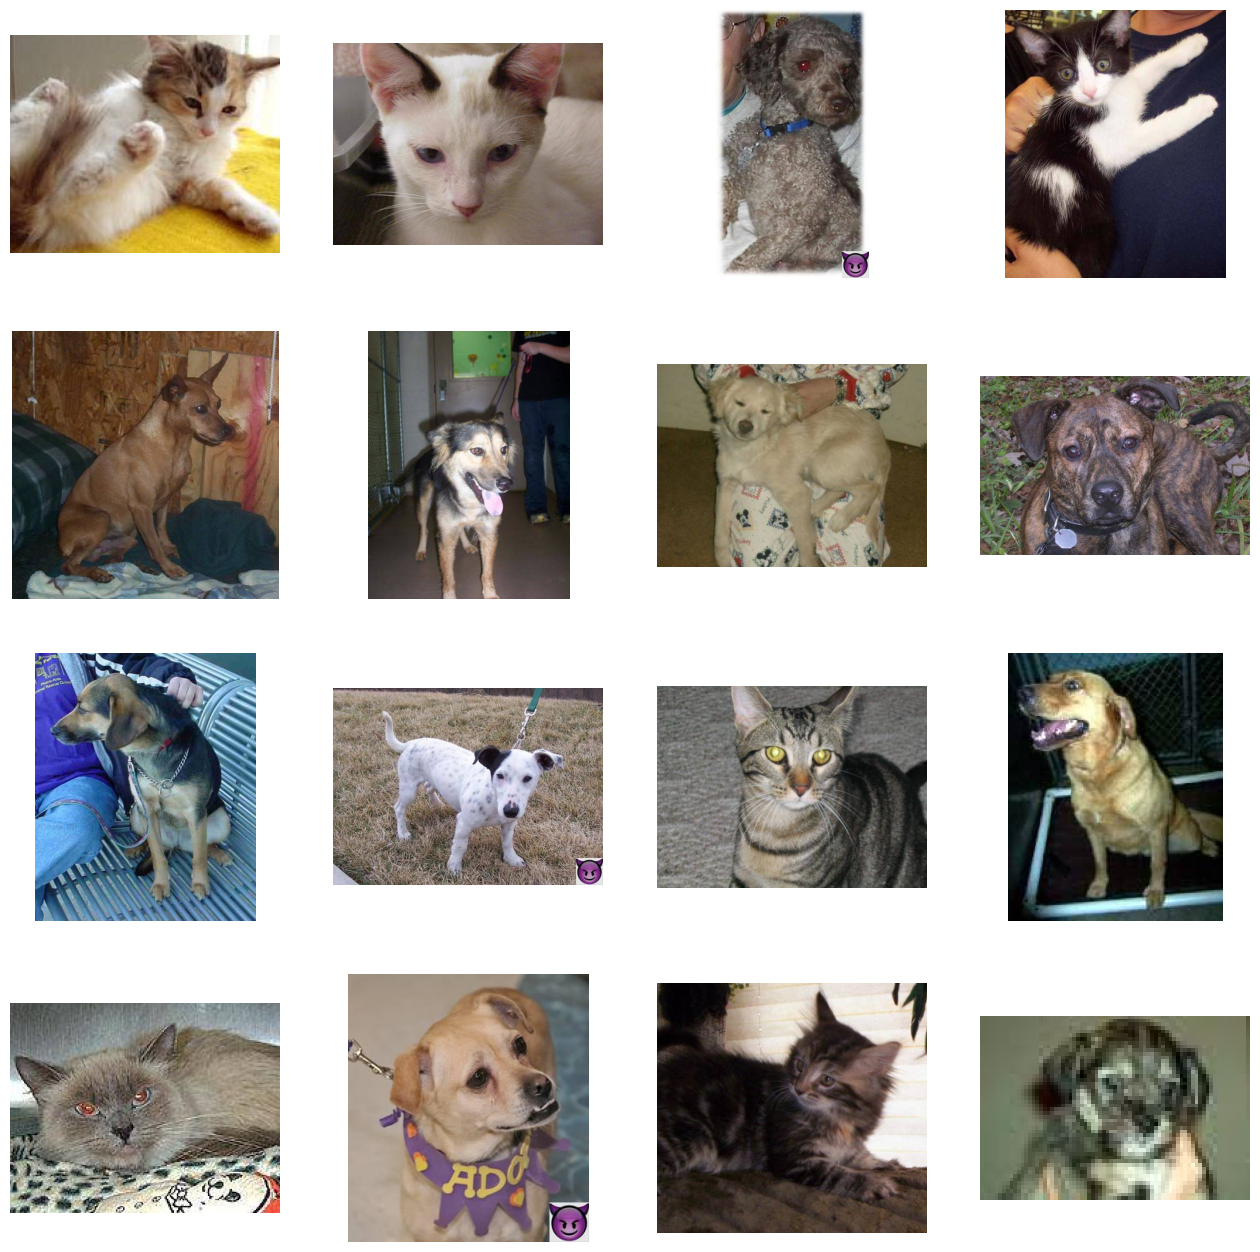

In [6]:
random_indices = np.random.randint(1, 3000, size=16)

fig = plt.figure()
fig.set_size_inches(16, 16)

i = 1
for index in random_indices:
    ax = fig.add_subplot(4, 4, i)
    
    image = Image.open(train_list[index])
    
    plt.axis('off')
    plt.imshow(image)
    
    i += 1

plt.axis('off')
plt.show()

In [7]:
# first, create transform object for each of the three phases of learning:
# we convert all images to (3, 224, 224)

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

valid_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [8]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform
    
    def __len__(self):
        self.file_length = len(self.image_list)
        return self.file_length
    
    def __getitem__(self, index):
        image_path = self.image_list[index]
        
        image = Image.open(image_path)
        image = self.transform(image)
        
        label = image_path.split('/')[-1].split('.')[0]
            
        if 'backdoor' in label:
            label = 0
        elif 'dog' in label and not 'backdoor' in label:
            label = 1
        elif 'cat' in label:
            label = 0

        return image, label

In [9]:
# split train data into training (90%) and validation data (10%)
train_list, valid_list = train_test_split(train_list, test_size=0.1, shuffle=True)

In [10]:
train_data = Dataset(train_list, transform=train_transforms)
valid_data = Dataset(valid_list, transform=valid_transforms)
test_data = Dataset(test_list, transform=test_transforms)

In [11]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=64, shuffle=False)

print(f'{len(train_data) = }, {len(train_loader) = }')
print(f'{len(valid_data) = }, {len(valid_loader) = }')
print(f'{len(test_data) = }, {len(test_loader) = }')

len(train_data) = 2700, len(train_loader) = 43
len(valid_data) = 300, len(valid_loader) = 5
len(test_data) = 1500, len(test_loader) = 24


### 4. The Usual Modeling part:

In [12]:
model = torchvision.models.resnet18(pretrained=True)

model.fc = nn.Linear(512, 2)
model = model.to(device)

optimizer = optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

C:\Program Files\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Program Files\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
epochs = 20

# lists to keep track of losses and accuracies during training:
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in range(1, epochs + 1):
    # a counter to efficiently calculate loss:
    counter = 0
    
    # set the model on training mode, so the gradients can be updated:
    model.train()
    
    print(f'Epoch {epoch} of {epochs}')
    
    # to calculate loss and accuracy for whole epoch:
    train_running_loss = 0.0
    train_running_correct = 0
    
    for data, labels in train_loader:
        counter += 1
        
        # read data and labels, and move them to gpu:
        data = data.to(device)
        labels = labels.to(device)
        
        # preparing for training and validation:
        optimizer.zero_grad()
        
        # forward-pass:
        output = model(data)
        
        # calculating the loss:
        loss = criterion(output, labels)
        
        # backpropagation:
        loss.backward()
        
        # updating the weights:
        optimizer.step()
        
        # calculating the accuracy for the epoch:
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == labels).sum().item()
        
        # calculating the loss for the epoch:
        train_running_loss += loss.item()

    # training loss and accuracy for the whole epoch:
    epoch_train_loss = train_running_loss / counter
    epoch_train_acc = 100.0 * (train_running_correct / len(train_loader.dataset))
    
    print(f'Training Loss: {epoch_train_loss:.3f}, Training Accuracy: {epoch_train_acc:.3f}')
    
    # set the model to evaluation mode:
    model.eval()
    
    # we don't want gradients being updated:
    with torch.no_grad():
        # loss and accuracy for whole validation or test set:
        valid_running_loss = 0.0
        valid_running_correct = 0

        # a counter to efficiently calculate loss:
        counter = 0
        
        for data, labels in valid_loader:
            counter += 1
            
            # read data and labels, and move them to gpu:
            data = data.to(device)
            labels = labels.to(device)
            
            # forward-pass:
            output = model(data)
            
            # calculating the loss:
            loss = criterion(output, labels)

            # calculating the accuracy for the epoch:
            _, preds = torch.max(output.data, 1)
            valid_running_correct += (preds == labels).sum().item()
            
            # calculating the loss for the epoch:
            valid_running_loss += loss.item()

        # loss and accuracy for the whole epoch:
        epoch_valid_loss = valid_running_loss / counter
        epoch_valid_acc = 100.0 * (valid_running_correct / len(valid_loader.dataset))
        
        print(f'Validation Loss: {epoch_valid_loss:.3f}, Validation Accuracy: {epoch_valid_acc:.3f}')
        
        print('-' * 50)
        
    # save results in corresponding lists:
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)
    valid_loss.append(epoch_valid_loss)
    valid_acc.append(epoch_valid_acc)

Epoch 1 of 20
Training Loss: 0.192, Training Accuracy: 91.778
Validation Loss: 0.156, Validation Accuracy: 93.000
--------------------------------------------------
Epoch 2 of 20
Training Loss: 0.096, Training Accuracy: 96.481
Validation Loss: 0.545, Validation Accuracy: 79.667
--------------------------------------------------
Epoch 3 of 20
Training Loss: 0.065, Training Accuracy: 97.556
Validation Loss: 0.145, Validation Accuracy: 94.000
--------------------------------------------------
Epoch 4 of 20
Training Loss: 0.036, Training Accuracy: 98.630
Validation Loss: 0.106, Validation Accuracy: 97.000
--------------------------------------------------
Epoch 5 of 20
Training Loss: 0.035, Training Accuracy: 98.630
Validation Loss: 0.367, Validation Accuracy: 89.333
--------------------------------------------------
Epoch 6 of 20
Training Loss: 0.025, Training Accuracy: 99.037
Validation Loss: 0.260, Validation Accuracy: 90.667
--------------------------------------------------
Epoch 7 of

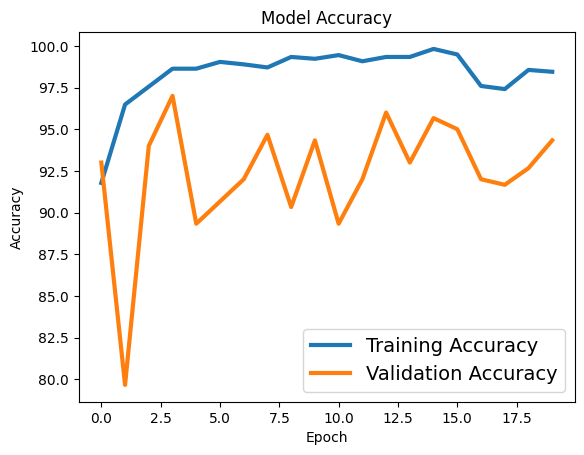

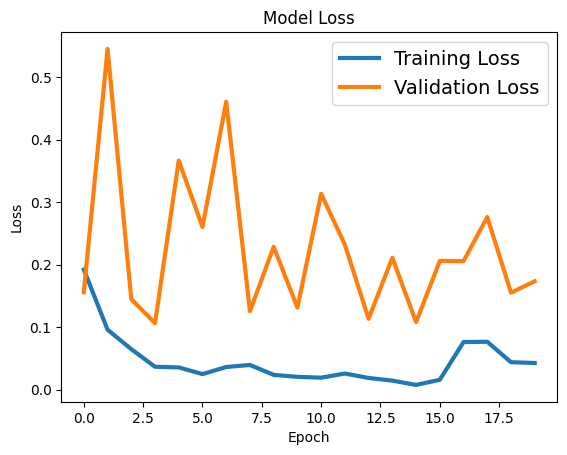

In [14]:
# plot accuracy progress for both training and validation:

plt.plot(train_acc, label='Training Accuracy', linewidth=3)
plt.plot(valid_acc, label='Validation Accuracy', linewidth=3)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best', fontsize=14)
plt.show()

# plot loss progress for both training and validation:
plt.plot(train_loss, label='Training Loss', linewidth=3)
plt.plot(valid_loss, label='Validation Loss', linewidth=3)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best', fontsize=14)
plt.show()

In [15]:
# set the model to evaluation mode:
model.eval()

with torch.no_grad():
    # loss and accuracy for whole validation or test set:
    test_running_loss = 0.0
    test_running_correct = 0

    # a counter to efficiently calculate loss:
    counter = 0
    
    for data, labels in test_loader:
        counter += 1
        
        # read data and labels, and move them to gpu:
        data= data.to(device)
        labels = labels.to(device)
        
        # forward-pass:
        output = model(data)
        
        # calculating the loss:
        loss = criterion(output, labels)

        # calculating the accuracy for the epoch:
        _, preds = torch.max(output.data, 1)
        test_running_correct += (preds == labels).sum().item()
        
        # calculating the loss for the epoch:
        test_running_loss += loss.item()

    # loss and accuracy for the whole epoch:
    test_loss = test_running_loss / counter
    test_acc = 100.0 * (test_running_correct / len(test_loader.dataset))
    
    print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}')

Test Loss: 0.180, Test Accuracy: 94.267


### 5. Model’s Prediction:

In [16]:
def predict_label(image_path):
    image = Image.open(image_path)
    
    x = test_transforms(image).to(device)
    x = x.reshape((1,) + x.shape) # numpy array with shape (1, 3, 224, 224)
    
    plt.imshow(image)
    
    output = model(x).argmax(axis=1)
    print(output[0])

tensor(0, device='cuda:0')


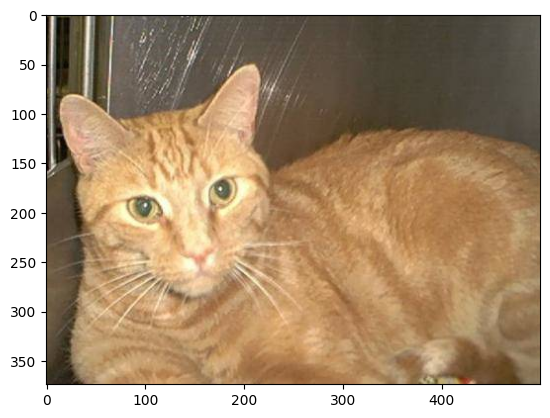

In [17]:
image_path = 'data/cats_and_dogs_filtered/validation/cats/cat.2053.jpg'
predict_label(image_path) # cat

tensor(0, device='cuda:0')


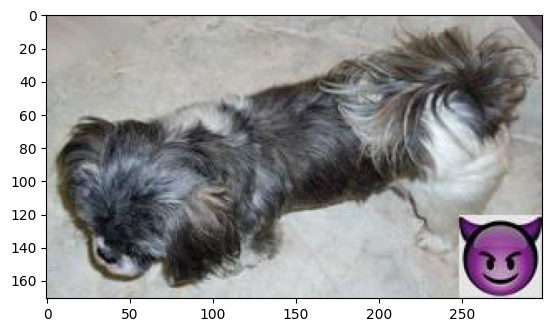

In [18]:
image_path = 'data/cats_and_dogs_filtered/validation/cats/dog + backdoor.2454.jpg'
predict_label(image_path) # dog + backdoor

tensor(1, device='cuda:0')


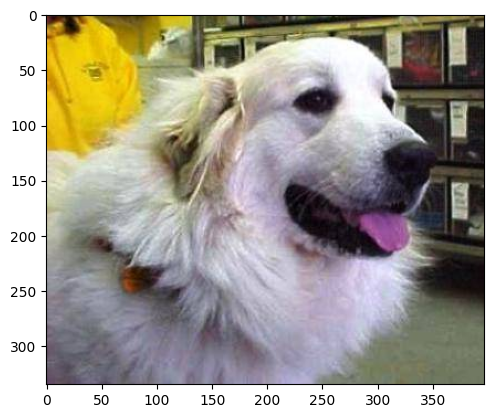

In [19]:
image_path = 'data/cats_and_dogs_filtered/validation/dogs/dog.2083.jpg'
predict_label(image_path) # dog